In [1]:
# standard libary and settings
import os
import sys

import numpy as np
import pandas as pd
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    KFold,
    train_test_split,
    StratifiedKFold,
    cross_val_score,
)
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.preprocessing import (
    StandardScaler,
    PolynomialFeatures,
    OrdinalEncoder,
    LabelEncoder,
    OneHotEncoder,
    KBinsDiscretizer,
)
from sklearn.svm import SVC, SVR
from category_encoders import WOEEncoder, TargetEncoder, CatBoostEncoder, BinaryEncoder, CountEncoder

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

try:
    import asdfasd
except ModuleNotFoundError:
    sys.path.append(
        "../../../mlmachine"
    ) if "../../../../mlmachine" not in sys.path else None
    sys.path.append(
        "../../../prettierplot"
    ) if "../../../../prettierplot" not in sys.path else None

    import mlmachine as mlm
    from mlmachine.data import titanic
    from mlmachine.features.preprocessing import (
        DataFrameSelector,
        PandasTransformer,
        KFoldEncoder,
        GroupbyImputer,
        PandasFeatureUnion,
        DualTransformer,
    )
    from prettierplot.plotter import PrettierPlot
    import prettierplot.style as style

c:\programdata\anaconda3\envs\petersont\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
import mlmachine as mlm
from mlmachine.data import titanic

df_train, df_valid = titanic()

ordinal_encodings = {"Pclass": [1, 2, 3]}

mlmachine_titanic_train = mlm.Machine(
    data=df_train,
    target="Survived",
    remove_features=["PassengerId","Ticket","Name"],
    identify_as_continuous=["Age","Fare"],
    identify_as_count=["Parch","SibSp"],
    identify_as_nominal=["Embarked","Cabin"],
    identify_as_ordinal=["Pclass"],
    ordinal_encodings=ordinal_encodings,
    is_classification=True,
)

mlmachine_titanic_valid = mlm.Machine(
    data=df_valid,
    remove_features=["PassengerId","Ticket","Name"],
    identify_as_continuous=["Age","Fare"],
    identify_as_count=["Parch","SibSp"],
    identify_as_nominal=["Embarked"],
    identify_as_ordinal=["Pclass"],
    ordinal_encodings=ordinal_encodings,
    is_classification=True,
)

>>> category label encoding

	0 --> 0
	1 --> 1



,Total missing,Percent missing
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467


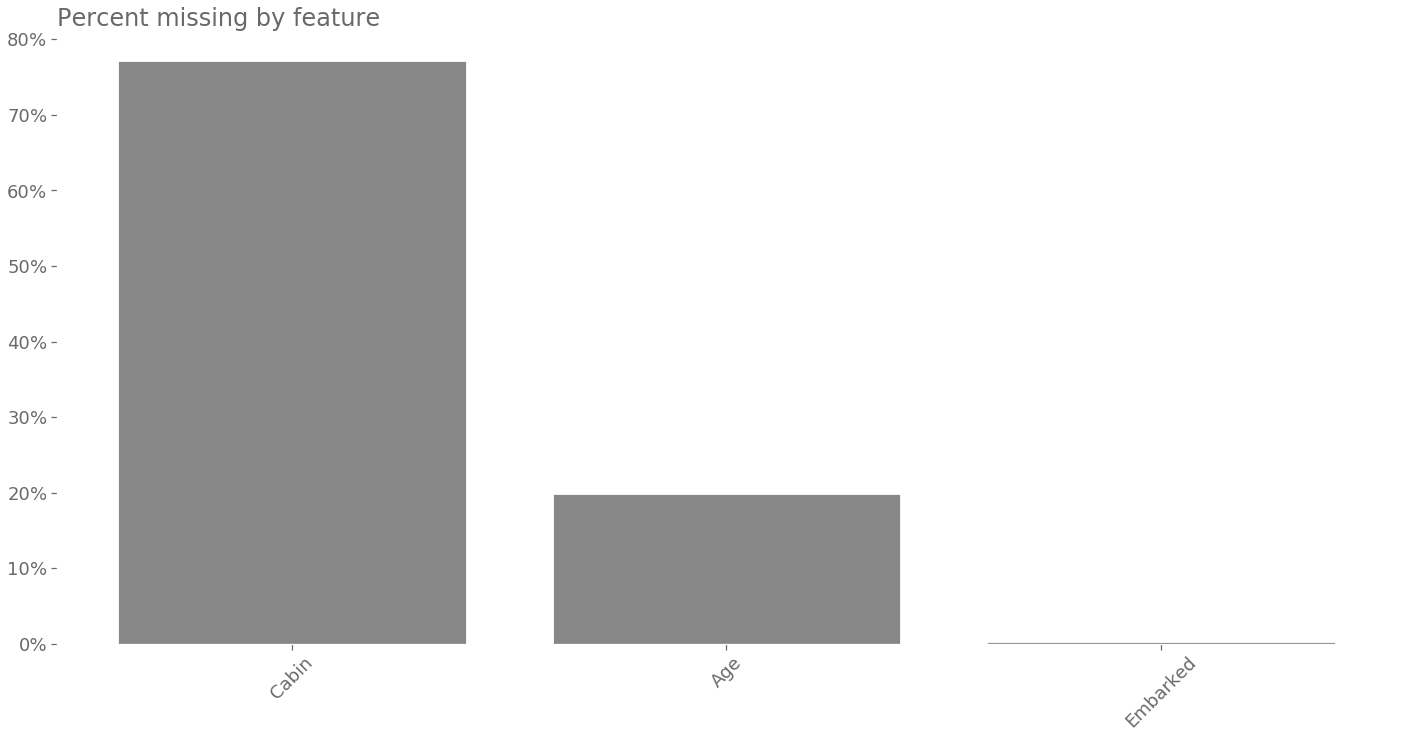

In [3]:
mlmachine_titanic_train.eda_missing_summary(display_df=True)

,Total missing,Percent missing
Cabin,327,78.229665
Age,86,20.574163
Fare,1,0.239234


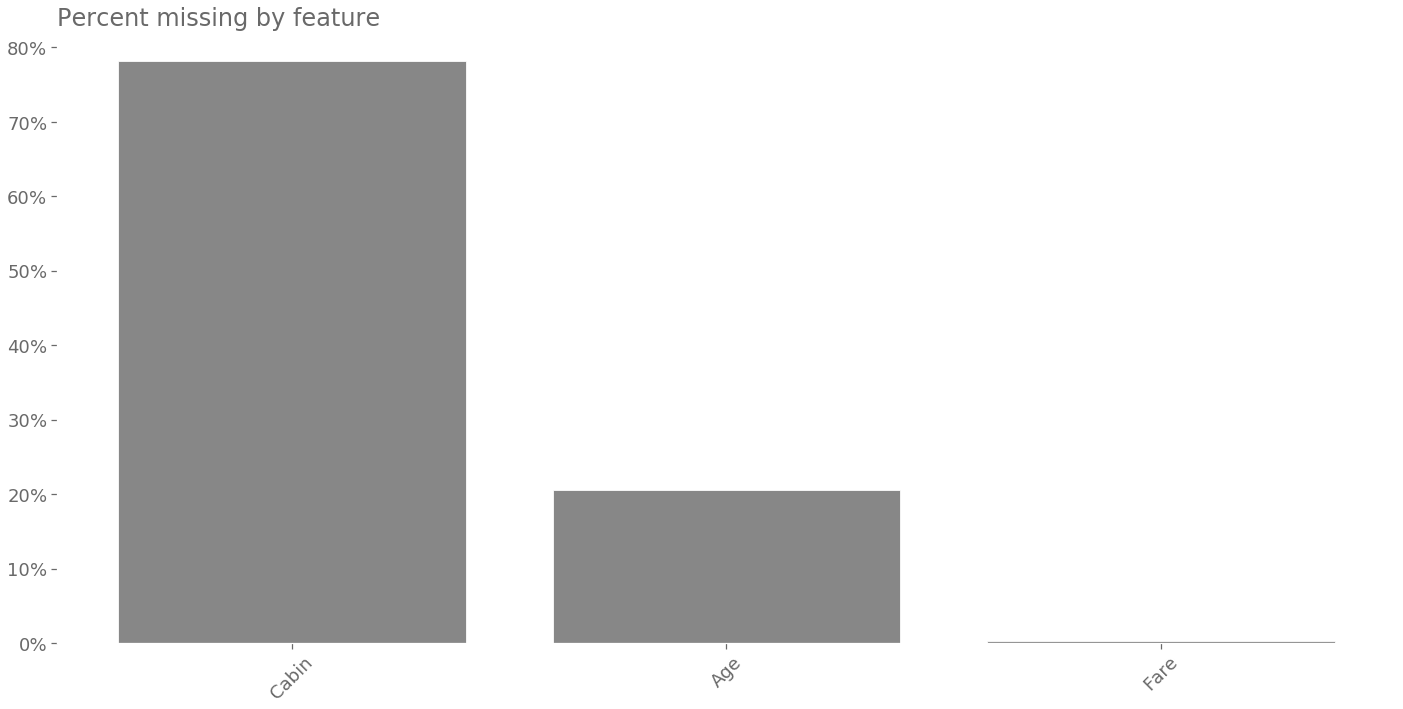

In [4]:
mlmachine_titanic_valid.eda_missing_summary(display_df=True)

In [5]:
mlmachine_titanic_train.missing_column_compare(
    validation_data=mlmachine_titanic_valid.data,
)

Feature has missing values in validation data, not training data.
{'Fare'}

Feature has missing values in training data, not validation data.
{'Embarked'}


In [6]:
impute = GroupbyImputer(null_column="Age", groupby_column="SibSp", strategy="mean")
impute.fit_transform(mlmachine_titanic_train.data[["Age","SibSp"]])
display(impute.train_value)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,SibSp,Age
0,0,31.397558
1,1,30.089727
2,2,22.620000
3,3,13.916667
4,4,7.055556
5,5,10.200000


In [7]:
impute_pipe = PandasFeatureUnion([
    ("age", make_pipeline(
        DataFrameSelector(include_columns=["Age","SibSp"]),
        GroupbyImputer(null_column="Age", groupby_column="SibSp", strategy="mean")
    )),
    ("fare", make_pipeline(
        DataFrameSelector(include_columns=["Fare","Pclass"]),
        GroupbyImputer(null_column="Fare", groupby_column="Pclass", strategy="mean")
    )),
    ("embarked", make_pipeline(
        DataFrameSelector(include_columns=["Embarked"]),
        PandasTransformer(SimpleImputer(strategy="most_frequent"))
    )),
    ("cabin", make_pipeline(
        DataFrameSelector(include_columns=["Cabin"]),
        PandasTransformer(SimpleImputer(strategy="constant", fill_value="X"))
    )),
    ("diff", make_pipeline(
        DataFrameSelector(exclude_columns=["Age","Fare","Embarked","Cabin"])
    )),
])

mlmachine_titanic_train.data = impute_pipe.fit_transform(mlmachine_titanic_train.data)
mlmachine_titanic_valid.data = impute_pipe.transform(mlmachine_titanic_valid.data)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [8]:
encode_pipe = PandasFeatureUnion([
    ("bin", make_pipeline(
        DataFrameSelector(include_columns=["Age"]),
        PandasTransformer(KBinsDiscretizer(encode="ordinal"))
    )),
    ("select", make_pipeline(
        DataFrameSelector(include_columns=["Age","Pclass"])
    )),
])

mlmachine_titanic_train.data = encode_pipe.fit_transform(mlmachine_titanic_train.data)
mlmachine_titanic_valid.data = encode_pipe.fit_transform(mlmachine_titanic_valid.data)

mlmachine_titanic_train.update_dtypes()
mlmachine_titanic_valid.update_dtypes()

In [9]:
target_encode_pipe = PandasFeatureUnion([
    ("target", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["category"], exclude_columns=["Cabin"]),        
        KFoldEncoder(
            target=mlmachine_titanic_train.target,
            cv=KFold(n_splits=5, shuffle=True, random_state=0),
            encoder=TargetEncoder,
        ),
    )),
    ("woe", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["category"]),
        KFoldEncoder(
            target=mlmachine_titanic_train.target,
            cv=KFold(n_splits=5, shuffle=False),
            encoder=WOEEncoder,
        ),
    )),
    ("catboost", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["category"]),
        KFoldEncoder(
            target=mlmachine_titanic_train.target,
            cv=KFold(n_splits=5, shuffle=False),
            encoder=CatBoostEncoder,
        ),
    )),
    ("diff", make_pipeline(
        DataFrameSelector(exclude_mlm_dtypes=["category"]),
    )),
])

mlmachine_titanic_train.data = target_encode_pipe.fit_transform(mlmachine_titanic_train.data)
mlmachine_titanic_valid.data = target_encode_pipe.transform(mlmachine_titanic_valid.data)

mlmachine_titanic_train.update_dtypes()
mlmachine_titanic_valid.update_dtypes()

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [10]:
mlmachine_titanic_train.skew_summary()

,Skew,Percent zero
Age,0.378296,0.0
Pclass_woe_encoded,0.440739,0.0
Pclass_target_encoded,0.486805,0.0
Pclass_catboost_encoded,0.488195,0.0
Age_binned_5_woe_encoded,0.896280,0.0
Age_binned_5_target_encoded,0.907149,0.0
Age_binned_5_catboost_encoded,1.013313,0.0


In [11]:
# skew correction pipeline
skew_pipe = PandasFeatureUnion([
    ("skew", make_pipeline(
        DataFrameSelector(include_columns=["Age"]),
        DualTransformer(),
    )),    
    ("diff", make_pipeline(
        DataFrameSelector(exclude_columns=["Age"]),
    )),
])

mlmachine_titanic_train.data = skew_pipe.fit_transform(mlmachine_titanic_train.data)
mlmachine_titanic_valid.data = skew_pipe.transform(mlmachine_titanic_valid.data)

mlmachine_titanic_train.update_dtypes()
mlmachine_titanic_valid.update_dtypes()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [12]:
mlmachine_titanic_train.skew_summary()

,Skew,Percent zero
Age_BoxCox,0.028608,0.007856
Age_YeoJohnson,0.048311,0.000000
Age,0.378296,0.000000
Pclass_woe_encoded,0.440739,0.000000
Pclass_target_encoded,0.486805,0.000000
Pclass_catboost_encoded,0.488195,0.000000
Age_binned_5_woe_encoded,0.896280,0.000000
Age_binned_5_target_encoded,0.907149,0.000000
Age_binned_5_catboost_encoded,1.013313,0.000000
